# Venmo Transactional Data

Recently I came across an interesting dataset that was collected using the Venmo API and scraping public transactions on Venmo from July-October 2018 and then again in January-February 2019. A more complete description of the dataset can be found [here, at Sa7mon's github](https://github.com/sa7mon/venmo-data). Most of the original, scraped data has been redacted for privacy but having recently looked at some customer segmentation literature, I wanted to see how feature engineering and clustering could be leveraged for some hypothetical use cases.

### Reading in the data

The data is stored in binary json, or bson. First, I will read in only a subset of the entire dataset to get started. I'd like to store it in a pandas dataframe and ultimately, export some other aggregations as csv files.

In [1]:
import pandas as pd
import bson #dont use pip install bson, use pip install pymongo instead
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
# import spacy
import emoji
import re
import numpy as np
import statistics
import csv
from tqdm import tqdm
from datetime import datetime

# progress bar
from tqdm import tqdm, tqdm_notebook

# instantiate
tqdm.pandas(tqdm_notebook)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
import ast

C:\Users\Stuart\.conda\envs\venmo\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Creating a one-time approach

First, I start by writing line by line and testing along the way. Once I have a functional bit of code, I will turn that into a function.

I started by using bson's decode_file_iter to decode the bson data from the locally-stored file and stored it in venmo_transactions. I added an empty dictionary to store records that would be parsed from the bson records.

<div class="alert alert-info">
    
```python3
venmo_transactions = bson.decode_file_iter(open('F:/Datasets/venmo/venmo.bson', 'rb'))

#create empty dict to store items of interest
conversion_dict = dict()
```

</div>

Once that is in, I set a limit on the number of transactions to parse. 

<div class="alert alert-info">
    
```python3
stop_at = 50000
```

</div>


Then, it loops through the transactions file and navigates the key-value pair structure of the bson. It was having some issues with navigating through null values (such as usernames, payment targets, etc) so some if else logic was used to handle that.

<div class="alert alert-info">

```python3
for c, d in enumerate(venmo_transactions):
    if d['payment'] != None:
        if d['payment']['target'] == None:
            target_username = d['payment']['target']['user']['username']
            target_user_id = d['payment']['target']['user']['id']
        else:
            target_username = None
            target_user_id = None
        target_type = d['payment']['target']['type']
        actor_username = d['payment']['actor']['username']
        actor_user_id = d['payment']['actor']['id']
        note = d['payment']['note']
        transaction_id = d['payment']['id']
        date_created = d['date_created']
        overall_type = d['type']

    else:
        target_type = None
        actor_username = None
        actor_user_id = None
        note = None
        transaction_id = None
```
</div>


After storing some items of interest from the bson, I put together a complete record ready for insertion into the dictionary and then assign it to the dictionary.

<div class="alert alert-info">

```python3
    record = {
        'transaction_id': transaction_id,
        'actor_user_id': actor_user_id,
        'actor_username': actor_username,
        'target_user_id': target_user_id,
        'target_username': target_username,
        'target_type': target_type,
        'overall_type': overall_type,
        'transaction_note': note,
        'date_created': date_created
    }
    conversion_dict[c] = record
```

</div>

Once it's in a dictionary, pandas handles the conversion to a dataframe and an export to a local file as a csv.


<div class="alert alert-info">

```python3
generated_df = pd.DataFrame.from_dict(conversion_dict, orient='index')

generated_df.to_csv(
    'C:/Users/Stuart/Documents/GitHub/venmo/data/output/smallerdf.csv')
```

In [2]:
# # Simple data processing

# #set the source of the data
# venmo_transactions = bson.decode_file_iter(
#     open('F:/Datasets/venmo/venmo.bson', 'rb'))

# #create empty dict to store items of interest
# conversion_dict = dict()

# #loop through transactions and store info of interest

# stop_at = 50000  #set number of iterations, and therefore records, to process
# for c, d in enumerate(venmo_transactions):
#     if d['payment'] != None:
#         if d['payment']['target'] == None:
#             target_username = d['payment']['target']['user']['username']
#             target_user_id = d['payment']['target']['user']['id']
#         else:
#             target_username = None
#             target_user_id = None
#         target_type = d['payment']['target']['type']
#         actor_username = d['payment']['actor']['username']
#         actor_user_id = d['payment']['actor']['id']
#         note = d['payment']['note']
#         transaction_id = d['payment']['id']
#         date_created = d['date_created']
#         overall_type = d['type']

#     else:
#         target_type = None
#         actor_username = None
#         actor_user_id = None
#         note = None
#         transaction_id = None

#     record = {
#         'transaction_id': transaction_id,
#         'actor_user_id': actor_user_id,
#         'actor_username': actor_username,
#         'target_user_id': target_user_id,
#         'target_username': target_username,
#         'target_type': target_type,
#         'overall_type': overall_type,
#         'transaction_note': note,
#         'date_created': date_created
#     }
#     conversion_dict[c] = record

#     if c == stop_at:  #exit on stop_at iteration
#         break

# #create a dataframe from the dictionary
# generated_df = pd.DataFrame.from_dict(conversion_dict, orient='index')

# #export dataframe as csv
# generated_df.to_csv(
#     'C:/Users/Stuart/Documents/GitHub/venmo/data/output/smallerdf.csv')

### Defining the read/export as a function

Hooray! The single use approach worked but I dont want to have to change constants throughout the code if I want an export of a different size. With that, I'll define a function to do the same thing. It wont be highly generalized as navigating the bson via the python dictionary is pretty specific. I'm not sure how one would get around that in a flexible way at this point.

In [2]:
def read_export_venmo_bson(filepath='',
                           exportpath='',
                           filename='venmo_export',
                           chunksize=250000):
    """
        reads bson venmo data from local file at filepath,
        captures transaction details specified within and stores
        as exported csv at exportpath with the filename and '.csv'
        """

    venmo_transactions = bson.decode_file_iter(open(filepath, 'rb'))

    # define a chunk list for writing separate csvs
    chunk_list = list(np.arange(0, 7076585, chunksize))
    chunk_list.append(7076585)
    
    print('using this as chunk list', chunk_list)

    # loop through transactions and store info of interest
    for position, chunk in enumerate(chunk_list):
        print('starting with chunk', chunk)
        
        conversion_dict = dict()

        for c, d in enumerate(venmo_transactions):
            # there's got to be a more elegant way to do this
            if c >= chunk and c < (chunk_list[(position+1)]):
                try:
                    if d['payment'] != None:
                        if d['payment']['target'] == None:
                            target_user_id = d['payment']['target']['user']['id']
                        else:
                            target_username = None
                            target_user_id = None
                        target_type = d['payment']['target']['type']
                        actor_user_id = d['payment']['actor']['id']
                        note = d['payment']['note']
                        transaction_id = d['payment']['id']
                        date_created = d['date_created']
                        overall_type = d['type']
                    else:
                        target_type = None
                        actor_username = None
                        actor_user_id = None
                        note = None
                        transaction_id = None
                        
                    record = {
                        'transaction_id': transaction_id,
                        'actor_user_id': actor_user_id,
                        'target_user_id': target_user_id,
                        'target_type': target_type,
                        'overall_type': overall_type,
                        'transaction_note': note,
                        'date_created': date_created
                    }
                    # add record to conversion_dict
                    conversion_dict[(chunk+c)] = record
                except exception as e:
                    print(e)
            elif c < chunk:
                continue
            else:
                break
        # generate dataframe from dictionary storing select info from above
        generated_df = pd.DataFrame.from_dict(conversion_dict,
                                              orient='index')
        print('exporting to csv now')
        generated_df.to_csv(str(exportpath) + str(filename) + str(chunk_list[position]) +"_" + str(chunk_list[(position+1)]) + '.csv')
        print('Function ran successfully.', str(chunk_list[position]),'to',str(chunk_list[(position+1)]),
              'records exported into table at:',
              exportpath + filename + str(chunk) + '.csv')


In [3]:
def read_export_venmo_bson_append(filepath='',
                           exportpath='',
                           filename='venmo_export'):
    """
        reads bson venmo data from local file at filepath,
        captures transaction details specified within and stores
        as exported csv at exportpath with the filename and '.csv'
    """

    venmo_transactions = bson.decode_file_iter(open(filepath, 'rb'))
    
    fields = ['transaction_id','actor_user_id','target_type','overall_type','transaction_note','date_created']
    length = 7076585
    
    with open(exportpath+filename, 'w') as csvfile: #encoding='utf-8'
        writer = csv.DictWriter(csvfile, fieldnames = fields)
        writer.writeheader()
        
        for c, d in enumerate(tqdm(venmo_transactions, total = length)):
            if d['payment'] != None:
                if d['payment']['target'] == None:
                    target_user_id = d['payment']['target']['user']['id']
                else:
                    target_username = None
                    target_user_id = None
                target_type = d['payment']['target']['type']
                actor_user_id = d['payment']['actor']['id']
                note = d['payment']['note']
                transaction_id = d['payment']['id']
                date_created = d['date_created']
                overall_type = d['type']
            else:
                target_type = None
                actor_username = None
                actor_user_id = None
                note = None
                transaction_id = None

            # add record to file
            try:

                #recode emojis to text
                note_demojized = emoji.demojize(note).encode(errors='ignore') #utf-8

                #assemble record to be written
                record = {
                        'transaction_id': transaction_id,
                        'actor_user_id': actor_user_id,
                        'target_type': target_type,
                        'overall_type': overall_type,
                        'transaction_note': note_demojized,
                        'date_created': date_created
                        }

                writer.writerow(record)

            except Exception as e:
                print('not able to add record at position', c, 'to file due to ', e)
                continue
    csvfile.close()

### Running the function

Time to see how it does!

In [4]:
bson_filepath = 'C:/Users/Stuart/Downloads/test/venmo.bson'
export_filepath = 'C:/Users/Stuart/Documents/GitHub/venmo/data/output/'
filename = 'transactions_csv_writer_attempt6_tqdm.csv'

read_export_venmo_bson_append(bson_filepath, export_filepath, filename)

 33%|███▎      | 2304461/7076585 [04:43<09:30, 8368.96it/s] 

not able to add record at position 2303408 to file due to  expected string or bytes-like object


100%|██████████| 7076585/7076585 [14:29<00:00, 8134.68it/s] 


# Data Transformation

Now that we have data in a set format, I'll look to see what data cleaning and wrangling steps are appropriate

In [16]:
transactions = pd.read_csv('C:/Users/Stuart/Documents/GitHub/venmo/data/output/transactions_csv_writer_attempt6_tqdm.csv')
transactions['transaction_note'] = [ast.literal_eval(x).decode('utf-8') for x in transactions['transaction_note']]
transactions.dtypes
transactions.head(15)

,transaction_id,actor_user_id,target_user_id,target_type,overall_type,transaction_note,date_created
0,2540405007077868184,2482900494712832556,NaN,user,payment,fuk ya,2018-08-07 02:11:16
1,2540405006884930468,2457721903251456771,NaN,user,payment,:automobile:,2018-08-07 02:11:16
2,2540405007379857710,2363395470786560486,NaN,user,payment,:venmo_dollar:,2018-08-07 02:11:16
3,2540404998227886310,1988829997170688939,NaN,user,payment,Gatorade,2018-08-07 02:11:15
4,2540404998613762676,2278060275531776951,NaN,user,payment,:party_popper:,2018-08-07 02:11:15
5,2540404999217741947,2256234518413312245,NaN,user,payment,China,2018-08-07 02:11:15
6,2540404999972717093,2085027231825920983,NaN,user,payment,Boyz,2018-08-07 02:11:15
7,2540404999746224995,2171413033123840693,NaN,user,payment,Tab,2018-08-07 02:11:15
8,2540404998253052168,2029336009900032272,NaN,user,payment,:cut_of_meat:,2018-08-07 02:11:15
9,2540405001474278289,1776499598295040973,NaN,user,payment,:dumpling::dumpling::dumpling:,2018-08-07 02:11:15


### checking shape

In [17]:
transactions.shape

(7076584, 7)

### Checking for null values

In [18]:
print('Field and Proportion of null values:\n\n',
      (transactions.isnull().sum() /
       transactions.isnull().count()).sort_values(ascending=False))

Field and Proportion of null values:

 target_user_id      1.0
date_created        0.0
transaction_note    0.0
overall_type        0.0
target_type         0.0
actor_user_id       0.0
transaction_id      0.0
dtype: float64


### Fixing datetime fields and re-indexing

In [19]:
transactions['date_created'] = pd.to_datetime(transactions['date_created'])
transactions = transactions.set_index(transactions['date_created'])

In [20]:
transactions.head(10)

,transaction_id,actor_user_id,target_user_id,target_type,overall_type,transaction_note,date_created
date_created,,,,,,,
2018-08-07 02:11:16,2540405007077868184,2482900494712832556,NaN,user,payment,fuk ya,2018-08-07 02:11:16
2018-08-07 02:11:16,2540405006884930468,2457721903251456771,NaN,user,payment,:automobile:,2018-08-07 02:11:16
2018-08-07 02:11:16,2540405007379857710,2363395470786560486,NaN,user,payment,:venmo_dollar:,2018-08-07 02:11:16
2018-08-07 02:11:15,2540404998227886310,1988829997170688939,NaN,user,payment,Gatorade,2018-08-07 02:11:15
2018-08-07 02:11:15,2540404998613762676,2278060275531776951,NaN,user,payment,:party_popper:,2018-08-07 02:11:15
2018-08-07 02:11:15,2540404999217741947,2256234518413312245,NaN,user,payment,China,2018-08-07 02:11:15
2018-08-07 02:11:15,2540404999972717093,2085027231825920983,NaN,user,payment,Boyz,2018-08-07 02:11:15
2018-08-07 02:11:15,2540404999746224995,2171413033123840693,NaN,user,payment,Tab,2018-08-07 02:11:15
2018-08-07 02:11:15,2540404998253052168,2029336009900032272,NaN,user,payment,:cut_of_meat:,2018-08-07 02:11:15


# Exploratory Data Analysis

### Transaction-Related

This section covers some insights about transactions, but not their contents.

#### Most Frequent User
First, I check how many transactions are associated with the most frequently-appearing user in this dataset.

In [21]:
top_10_frequencies = pd.DataFrame(transactions.actor_user_id.value_counts()[:10])
top_10_frequencies = top_10_frequencies.reset_index()

top_10_frequencies.columns = ['actor_user_id', 'frequency']
top_10_frequencies
print('The most frequently appearing user in the dataset is associated with', top_10_frequencies.iloc[0,1], 'transactions.')

The most frequently appearing user in the dataset is associated with 359 transactions.


Let's take a deeper dive into this userID and see what they are doing on here.

In [22]:
top_user_df = transactions[transactions['actor_user_id'] == top_10_frequencies.actor_user_id[0]]
print(top_user_df.head(5))
top_user_df.transaction_note.unique()

                          transaction_id        actor_user_id  target_user_id  \
date_created                                                                    
2018-07-27 06:18:51  2532557086252859540  2135126842540032910             NaN   
2018-07-27 08:38:49  2532627535519285497  2135126842540032910             NaN   
2018-07-27 09:18:48  2532647663967404894  2135126842540032910             NaN   
2018-07-27 12:18:31  2532738119795474850  2135126842540032910             NaN   
2018-07-27 13:18:34  2532768344445026382  2135126842540032910             NaN   

                    target_type overall_type  \
date_created                                   
2018-07-27 06:18:51        user      payment   
2018-07-27 08:38:49        user      payment   
2018-07-27 09:18:48        user      payment   
2018-07-27 12:18:31        user      payment   
2018-07-27 13:18:34        user      payment   

                                          transaction_note        date_created  
date_created  

array(['1254498980 public to private audience',
       '2195330274 public to friends audience',
       '2149315512 public to private audience',
       '306393817 public to friends audience',
       '3873500785 public to friends audience',
       '211998185 public to friends audience',
       '1191318999 public to friends audience',
       '70123582 public to private audience',
       '4134537904 public to private audience',
       '1956045026 public to friends audience',
       '2493813432 public to private audience',
       '3703065137 public to private audience',
       '1048350090 public to private audience',
       '2516045715 public to friends audience',
       '3182782327 public to private audience',
       '564282687 public to friends audience',
       '2338340830 public to private audience',
       '3522610659 public to friends audience',
       '2535032764 public to friends audience',
       '348733281 public to private audience',
       '3808227831 public to friends audience'

### Overall Transactions Per User

Text(0.5, 1.0, 'Frequency of Transactions per Users')

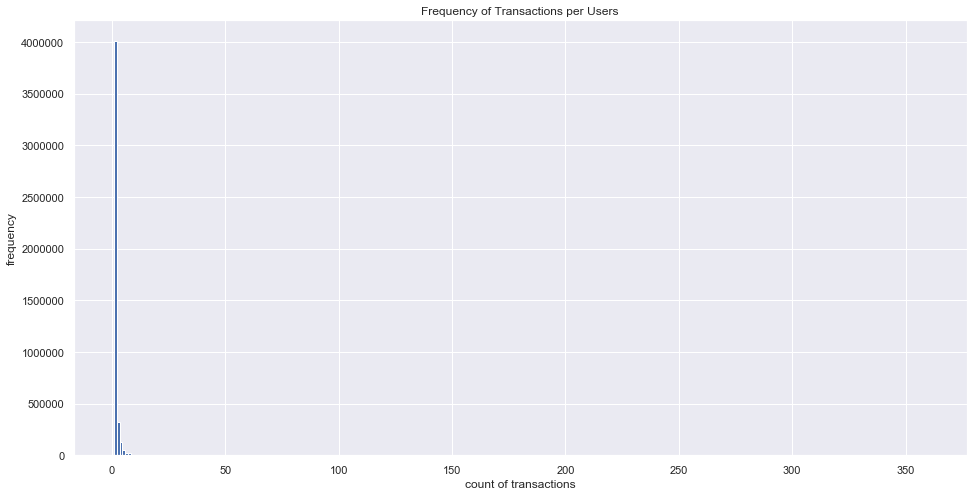

In [23]:
### VISUALIZATION:HISTOGRAM OF TRANSACTION COUNT PER USER ID
group_by =  transactions[['actor_user_id','transaction_id']].groupby(by='actor_user_id', as_index = False, sort= False).count()
group_by.columns = ['actor_user_id', 'transaction_count']
group_by['log_plus_one_counts'] = np.log(group_by['transaction_count'])+1

# group_by.plot(kind='hist',bins=50)
plot = group_by.transaction_count.hist(bins=300, figsize=(16, 8))
plot.set_xlabel('count of transactions')
plot.set_ylabel('frequency')
plot.set_title('Frequency of Transactions per Users')

### Weekly Transaction Frequency by Users

<ipython-input-31-e4a8b88aaeb7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_by['weeknum'] = [datetime.strftime(i, '%U') for i in group_by.index]


Text(0.5, 1.0, 'Distribution of Average Weekly Transaction Counts per User')

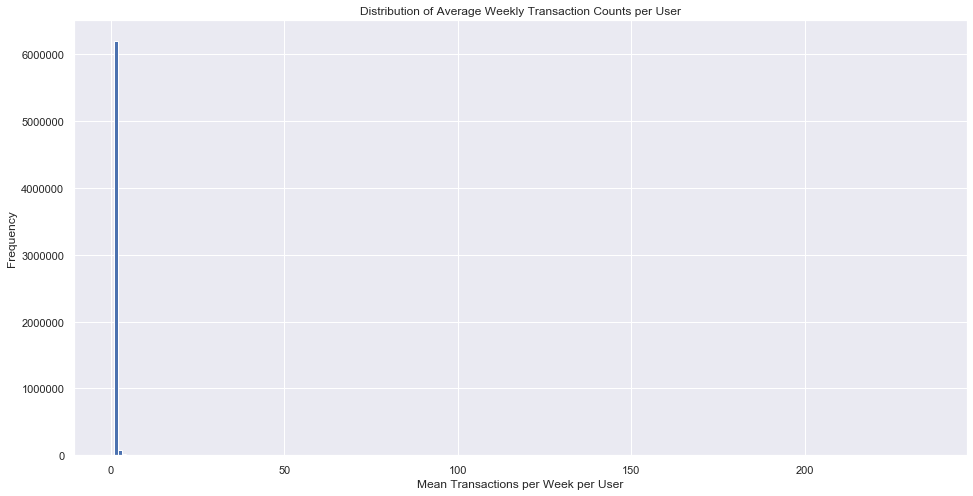

In [31]:
### VISUALIZATION: HISTOGRAM OF TRANSACTION COUNTS PER WEEK PER USER
group_by = transactions[['actor_user_id','transaction_id']]
group_by['weeknum'] = [datetime.strftime(i, '%U') for i in group_by.index]
data = pd.DataFrame(group_by.groupby(by=['weeknum','actor_user_id']).count())
plot = data.transaction_id.hist(bins=200, figsize=(16, 8))
plot.set_xlabel('Mean Transactions per Week per User')
plot.set_ylabel('Frequency')
plot.set_title('Distribution of Average Weekly Transaction Counts per User')

### Monthly Transaction Frequency by Users

<ipython-input-33-951966f53efb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_by['monthnum'] = [datetime.strftime(i, '%m') for i in group_by.index]


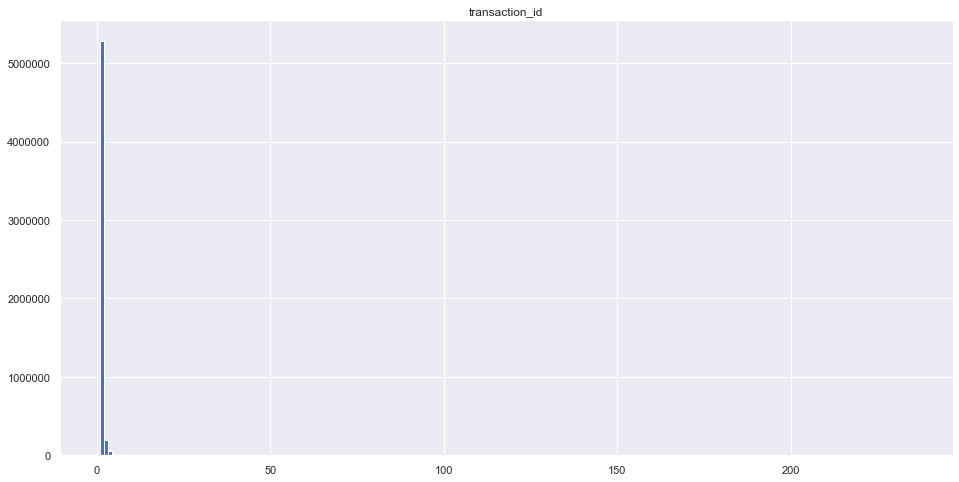

In [33]:
### VISUALIZATION: HISTOGRAM OF TRANSACTION COUNTS PER MONTH PER USER
group_by = transactions[['actor_user_id','transaction_id']]
group_by['monthnum'] = [datetime.strftime(i, '%m') for i in group_by.index]
data = pd.DataFrame(group_by.groupby(by=['monthnum','actor_user_id']).count())
plot = data.hist(column='transaction_id', bins=200, figsize=(16, 8))
# plot.set_xlabel('Mean Transactions per Month per User')
# plot.set_ylabel('Frequency')
# plot.set_title('Distribution of Average Monthly Transaction Counts per User')

### Transactions by Date


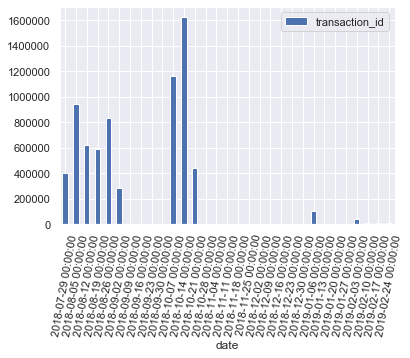

<Figure size 864x360 with 0 Axes>

In [56]:
transactions_by_date = pd.DataFrame(transactions.groupby(transactions.index.date).count())
transactions_by_date = transactions_by_date[['transaction_id']]

transactions_by_date.index = pd.to_datetime(transactions_by_date.index)
t_by_w = transactions_by_date.resample('w').sum()
t_by_w['date'] = t_by_w.index
t_by_w.plot(x='date', y='transaction_id', kind='bar')
plt.xticks(rotation=80)
plt.figure(figsize=(12,5))
plt.show()

Personally, I know how I have used venmo in different periods of life. My own use is really just a sample size of one but I suspect that some of the frequent uses of the app are to:

1) split bills for a social events among friends (a bar tab, lunch, drinks, etc) or just paying your friends for little things they pick up. 

I suspect that split amounts would be interesting in that they would have more precision than gift amounts, generally. If this data contained the transaction amounts, I may use a regular expression to check for amounts ending in non zero digits, or even those that end with two nonzero digits like 13.41. It seems reasonable that most people don't specify down to the cent when sending gift money or rent money. Transactions in this group may feature notes like "Dinner", "coffee", "lunch", "breakfast", "drinks", "alcohol", etc. 
    

2) gift money to people

ex: sending 5 bucks for a coffee or for a birthday. Perhaps parents send some funds to have a celebration dinner after a kid does well on a college exam. I'm not sure how these may show up in these transactions. They may contain notes like "Congratulations" or "love y*" or "knew you could do it"

3) splitting bills

I'll check for "rent" in the notes and possibly the house emoji. Emojis are amazingly popular on venmo. I may check in transactions in the last 3 days of each month or first 2 days of the subsequent. I imagine these would be larger amounts, but with no cents specified if the transaction amounts were visible.

---------------------------------

To start, I'll need to clean up the transaction notes.

## Topic Related


In [57]:
#focus in on columns of interest only
transactions = transactions[[
    'transaction_id', 'actor_user_id', 'transaction_note', 'date_created'
]]

#drop any rows with NaN, as we want to work with the notes anyway
transactions = transactions.dropna()

#append word counts of notes column
transactions['word_count'] = transactions['transaction_note'].apply(
    lambda x: len(str(x).split(" ")))

transactions.sample(10)

,transaction_id,actor_user_id,transaction_note,date_created,word_count
date_created,,,,,
2018-10-11 15:22:56,2587913890188755485,2401276386082816398,Cute tires :),2018-10-11 15:22:56,3
2018-08-10 00:20:02,2542523348374520335,1882894192607232348,:rocket_popsicle::festival_floaty:,2018-08-10 00:20:02,1
2018-10-04 02:43:47,2582458367020630853,2526655977357312504,Wireless extender,2018-10-04 02:43:47,2
2018-07-28 15:26:19,2533557417715696502,1566343249788928422,Wine,2018-07-28 15:26:19,1
2018-10-14 09:55:52,2589923604011418308,1869393600446464106,Vegas,2018-10-14 09:55:52,1
2019-01-05 20:00:18,2650384211755663434,2318383836037120793,Tons of fun,2019-01-05 20:00:18,3
2018-10-12 21:47:31,2588832233049555671,2103797547532289018,:sad_but_relieved_face:,2018-10-12 21:47:31,1
2018-10-11 23:18:10,2588153081313100027,2290782883020801012,friday,2018-10-11 23:18:10,1
2018-07-26 23:01:30,2532336966100320704,1491721556852736581,Gas bill,2018-07-26 23:01:30,2


I'm interested in classifying on some features that may be derived from the transaction notes, so I will use some text preprocessing steps. I'm also curious about explicit mentioning of companies names as substitutions for a service they provide (ex: "Uber" meaning rideshare, whether or not it was accessed using uber).

I'm starting with a frequency based approach using bag of words (BoW). BoW doesn't preserve the ordering of words in a sentence, but rather looks at the occurrence of each word among a collection of documents. Each text is analyzed and placed into a sparse matrix where each column codes for the occurrence of a word word and each row represents a document (here, a notes). The intersection tells whether the text document contains the word coded by each column. This is a sparse matrix, as not every document would have every word present. Each individual document is likely to only have some small portion of the possible words among the matrix in most cases I can imagine.

Before getting into all that, I need to do some text preprocessing steps.

In [59]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
# from textblob import TextBlob


def nltk_twitter_tokenize(text):
    """ tokenizes text using nltk word tokenizer"""
    tokens = word_tokenize(text)
    return tokens


def replace_stopwords(text):
    """ uses nltk english stopwords list to remove stopwords from text"""
    words = [w for w in text if w not in stopwords.words('english')]
    return words


def lemmatize_text(text):
    """ lemmatizes words using nltk wordnetlemmatizer"""
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(w) for w in text]
    return lemmatized_text


def spellcheck_correct(text):
    """uses textblob correct function to correct misspellings"""
    output = TextBlob(text).correct()
    return output


# def detect_language(text):
#     """ determines language using google translate from TextBlob"""
#     blob = TextBlob(text)
#     lang = blob.detect_language()
#     return lang


# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


def drop_punctuation(text):
    """ removes punctuation from string based on list included inside function"""
    punct = [
        '!', '@', '#', '$', '%', '^', '&', '*', "'", '*', '.', ',', '/', ':',
        ';', '"', "(", ")"
    ]
    clean_string = "".join(character for character in text
                           if character not in punct)
    return clean_string


# def keep_nouns(text):
#     """ use part of speech tagging to filter out any tokens where part of speech is not noun"""
#     output = []
#     for doc in nlp.pipe(text):
#         noun_text = " ".join(token.lemma_ for token in doc
#                              if token.pos_ == 'NOUN')
#         output.append(noun_text)
#     return output


def remove_emojis(text):
    """use emoji package to strip emojis from text"""
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join(
        [str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text


def isolate_emojis(text):
    """use emoji package to extract emojis from text"""
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join(
        [str for str in text.split() if not any(i in str for i in emoji_list)])
    return emoji_list

In [64]:
#working with emojis

#separate notes from emojis
transactions['note_no_emojis'] = transactions.transaction_note.progress_apply(
    lambda x: remove_emojis(x))

#separate emojis from notes and store separately
transactions['emojis_alone'] = transactions.transaction_note.progress_apply(
    lambda x: isolate_emojis(x))

#split apart chained emojis
transactions['note_no_emojis'] = transactions['note_no_emojis'].progress_apply(lambda x: x.replace("::", " ").replace(":", " "))

#some note texts had punctuation so I need to drop that
transactions['note_no_emojis'] = transactions.note_no_emojis.progress_map(
    lambda x: x.translate(str.maketrans('', '', string.punctuation)))


transactions.head(15)

100%|██████████| 7076584/7076584 [00:27<00:00, 258570.85it/s]


,transaction_id,actor_user_id,transaction_note,date_created,word_count,note_no_emojis,emojis_alone,emoji_set,tokens,note_sans_stopwords,note_lemmatized,note,note_str
date_created,,,,,,,,,,,,,
2018-08-07 02:11:16,2540405007077868184,2482900494712832556,fuk ya,2018-08-07 02:11:16,2,fuk ya,[],[],"[fuk, ya]","[fuk, ya]","[fuk, ya]","[fuk, ya]",fuk ya
2018-08-07 02:11:16,2540405006884930468,2457721903251456771,:automobile:,2018-08-07 02:11:16,1,automobile,[],[],[automobile],[automobile],[automobile],[automobile],automobile
2018-08-07 02:11:16,2540405007379857710,2363395470786560486,:venmo_dollar:,2018-08-07 02:11:16,1,venmodollar,[],[],[venmodollar],[venmodollar],[venmodollar],[venmodollar],venmodollar
2018-08-07 02:11:15,2540404998227886310,1988829997170688939,Gatorade,2018-08-07 02:11:15,1,Gatorade,[],[],[Gatorade],[Gatorade],[Gatorade],[gatorade],gatorade
2018-08-07 02:11:15,2540404998613762676,2278060275531776951,:party_popper:,2018-08-07 02:11:15,1,partypopper,[],[],[partypopper],[partypopper],[partypopper],[partypopper],partypopper
2018-08-07 02:11:15,2540404999217741947,2256234518413312245,China,2018-08-07 02:11:15,1,China,[],[],[China],[China],[China],[china],china
2018-08-07 02:11:15,2540404999972717093,2085027231825920983,Boyz,2018-08-07 02:11:15,1,Boyz,[],[],[Boyz],[Boyz],[Boyz],[boyz],boyz
2018-08-07 02:11:15,2540404999746224995,2171413033123840693,Tab,2018-08-07 02:11:15,1,Tab,[],[],[Tab],[Tab],[Tab],[tab],tab
2018-08-07 02:11:15,2540404998253052168,2029336009900032272,:cut_of_meat:,2018-08-07 02:11:15,1,cutofmeat,[],[],[cutofmeat],[cutofmeat],[cutofmeat],[cutofmeat],cutofmeat


In [ ]:
sns.distplot(transactions['word_count'], bins=25, kde=False, rug=True)
plt.ylabel('Frequency')
plt.xlabel('Word Count')
plt.title('Distribution of Word Counts across transactions')

In [ ]:

# transactions['note_spellchecked'] = transactions['note_sans_emojis'].apply(lambda txt: ''.join(spellcheck_correct(txt)))
# transactions.sample(10)
# well, spellcheck sucks...

In [65]:
#handling note texts
from tqdm import tqdm
tqdm.pandas()

#emojis are often repeated, creating a set from them may simplify things later.
transactions['emoji_set'] = transactions['emojis_alone'].progress_map(
    lambda x: list(set(x)))



#tokenize notes
transactions['tokens'] = transactions['note_no_emojis'].progress_apply(
    lambda x: nltk_twitter_tokenize(x))

#remove stopwords
transactions['note_sans_stopwords'] = transactions['tokens'].progress_apply(
    lambda x: replace_stopwords(x))

#lemmatize notes
transactions['note_lemmatized'] = transactions['note_sans_stopwords'].progress_apply(
    lambda x: lemmatize_text(x))

#make lowercase
transactions['note'] = transactions['note_lemmatized'].progress_apply(
    lambda x: [str.lower(i) for i in x])

#join note text to one string
transactions['note_str'] = transactions.note.progress_apply(lambda x: str(' '.join(x)))

transactions.head(50)

C:\Users\Stuart\.conda\envs\venmo\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 7076584/7076584 [00:23<00:00, 297414.47it/s]


,transaction_id,actor_user_id,transaction_note,date_created,word_count,note_no_emojis,emojis_alone,emoji_set,tokens,note_sans_stopwords,note_lemmatized,note,note_str
date_created,,,,,,,,,,,,,
2018-08-07 02:11:16,2540405007077868184,2482900494712832556,fuk ya,2018-08-07 02:11:16,2,fuk ya,[],[],"[fuk, ya]","[fuk, ya]","[fuk, ya]","[fuk, ya]",fuk ya
2018-08-07 02:11:16,2540405006884930468,2457721903251456771,:automobile:,2018-08-07 02:11:16,1,automobile,[],[],[automobile],[automobile],[automobile],[automobile],automobile
2018-08-07 02:11:16,2540405007379857710,2363395470786560486,:venmo_dollar:,2018-08-07 02:11:16,1,venmodollar,[],[],[venmodollar],[venmodollar],[venmodollar],[venmodollar],venmodollar
2018-08-07 02:11:15,2540404998227886310,1988829997170688939,Gatorade,2018-08-07 02:11:15,1,Gatorade,[],[],[Gatorade],[Gatorade],[Gatorade],[gatorade],gatorade
2018-08-07 02:11:15,2540404998613762676,2278060275531776951,:party_popper:,2018-08-07 02:11:15,1,partypopper,[],[],[partypopper],[partypopper],[partypopper],[partypopper],partypopper
2018-08-07 02:11:15,2540404999217741947,2256234518413312245,China,2018-08-07 02:11:15,1,China,[],[],[China],[China],[China],[china],china
2018-08-07 02:11:15,2540404999972717093,2085027231825920983,Boyz,2018-08-07 02:11:15,1,Boyz,[],[],[Boyz],[Boyz],[Boyz],[boyz],boyz
2018-08-07 02:11:15,2540404999746224995,2171413033123840693,Tab,2018-08-07 02:11:15,1,Tab,[],[],[Tab],[Tab],[Tab],[tab],tab
2018-08-07 02:11:15,2540404998253052168,2029336009900032272,:cut_of_meat:,2018-08-07 02:11:15,1,cutofmeat,[],[],[cutofmeat],[cutofmeat],[cutofmeat],[cutofmeat],cutofmeat


Export to CSV

In [66]:
transactions.to_csv("../../data/output/transactions_processed.csv", chunksize=100000, mode='a')

In [ ]:
from collections import Counter

word_frequencies = Counter()
word_ignore = ["’"]
transactions['note'].apply(word_frequencies.update)
for word in list(word_frequencies):
    if word in word_ignore:
        del word_frequencies[word]

print('Most common words:', word_frequencies.most_common(10))

emoji_frequencies = Counter()

transactions['emoji_set'].apply(emoji_frequencies.update)
print('Most common emojis:', emoji_frequencies.most_common(10))

plt.figure(figsize=(15, 6))

n_items = 15
plt.subplot(1, 2, 1)
plt.xticks(rotation=70)
plt.bar([x[0] for x in word_frequencies.most_common(n_items)],
        [x[1] for x in word_frequencies.most_common(n_items)])
plt.title('Most common words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.bar([x[0] for x in emoji_frequencies.most_common(n_items)],
        [x[1] for x in emoji_frequencies.most_common(n_items)])
plt.xticks(rotation=90)
plt.title('Most common emojis')

In [ ]:
# POS tagging and filtering for nouns alone

#English multi-task CNN trained on OntoNotes.
#Assigns context-specific token vectors, POS tags, dependency parse and named entities.
# use "python -m spacy download en_core_web_sm" if you need to download it
df_nouns = transactions[['transaction_id', 'note']].copy()

df_nouns['nouns_only'] = keep_nouns(transactions['note_str'])
df_nouns =  df_nouns[~(df_nouns.nouns_only == '')]

df_nouns.sample(20)

# Machine Learning

## Using TF-IDF on Nouns only

In [ ]:
# tf-idf: Term-frequency inverse document frequency on just the nouns

# number of topics to extract
n_topics = 2  # not an exact science here, just picking a value to start and see what we get
random_state = 0



vectorizer = TfidfVectorizer(max_features=200, stop_words="english", max_df = 0.85)
features = vectorizer.fit_transform(df_nouns.nouns_only)


## Non-Negative Matrix Factorization

Non-Negative Matrix Factorization is not as flexible for finding a lot of topics among longer documents but the computation is reduced when compared to LDA. With the short documents here, it may do just fine but once a suitable number of topics is produced, I'll also look at implementing LDA with the whole dataset.

In [ ]:
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

feature_names = vectorizer.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 20

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words - 1:-1]:
        print(feature_names[fid], end=' ')
    print()

### Full Transactions Dataframe

In [136]:
# tf-idf: Term-frequency inverse document frequency

# number of topics to extract
n_topics = 5  # not an exact science here, just picking a value to start and see what we get
random_state = 0

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=250, stop_words="english", max_df = 0.85)
# features = vectorizer.fit_transform(df_nouns.nouns_only)
features = vectorizer.fit_transform(transactions['note_str'])

from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit_transform(features)

feature_names = vectorizer.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 10

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words - 1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 bfood stuff drink food gas beer tip uber thank redheart 
1 buber home night automobile uber ride house food drink thank 
2 bpizza pizza party beer time beermug night uber thank thanks 
3 bfor splitwisecom good best food love time night friend thank 
4 bhousemoneywithwings rent august october baugust 2018 housemoneywithwings deposit july food 


In [146]:
cls.components_[0]

array([3.31571522e-04, 7.32807220e-04, 9.77922785e-04, 8.15930336e-04,
       1.04247263e-04, 4.06139212e-04, 1.06096922e-02, 7.57619191e-06,
       2.58618730e-05, 1.05478315e-03, 3.86911460e-05, 1.58989704e-04,
       5.22540790e-05, 1.05294444e-03, 1.64443453e-04, 7.99371838e-05,
       2.46883866e-05, 1.78642405e-04, 1.34300278e-04, 4.14854856e-05,
       1.36899355e-04, 8.97812693e-05, 6.13125782e-05, 2.33147321e-05,
       2.31937291e-05, 4.21729620e-05, 1.61321103e-05, 1.93311637e-04,
       4.41080009e-05, 1.65416348e-04, 1.35172096e-05, 8.09672826e-05,
       1.09423346e-05, 9.82623168e-05, 1.00437898e-03, 2.18502329e-05,
       2.31500744e-04, 4.02557019e-04, 4.49482500e-05, 6.33029712e-06,
       1.07256341e-04, 7.18862488e-06, 2.21495584e-02, 9.97579141e-03,
       2.60470476e-06, 5.92125583e-05, 1.35355235e-03, 4.19915529e-06,
       9.27597584e-05, 6.35293895e-06, 2.88771505e-06, 1.56088350e-05,
       1.24512618e-05, 1.77261246e+01, 0.00000000e+00, 1.50888341e-05,
      

In [ ]:
%%time
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 8
number_words = 10

#set data
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
lda_features = count_vectorizer.fit_transform(transactions['note_str'])

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)

lda.fit(lda_features)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

In [ ]:
%%time
overall_scores = []
lowest_observed_mean = 1.0

for feature_num in range(100, 1000, 100):
    print(feature_num)
    vectorizer = TfidfVectorizer(max_features=feature_num,
                                 stop_words="english",
                                 max_df=0.85)

    features = vectorizer.fit_transform(transactions['note_str'])
    feature_names = vectorizer.get_feature_names()
    
    for topicnumber in range(2, 15, 1):
        cls = NMF(n_components=topicnumber, random_state=0)
        cls.fit(features)

        #parse the components by position
        for j in range(len(cls.components_)):

            #extract most important words among 1/2 of the total feature_num words
            word_set = set([
                feature_names[i]
                for i in cls.components_[j].argsort().tolist()
                [-1:-(int(feature_num / 2)) - 1:-1]
            ])

            #store the length of the set of words
            denominator = len(word_set)

            #store components as list, others
            others = cls.components_

            #delete others array that would compare identical sets for use in subsequent loop
            others[j] = np.zeros(cls.components_[j].shape)

            #create a list to store the proportion of overlap
            topic_overlap_list = [0]

            #loop over all components minus the one in the prior loop
            for k in range(len(others)):

                #store the most important 1/2 of words for comparison against the prior component
                comparison_set = set([
                    feature_names[i] for i in others[k].argsort().tolist()
                    [-1:-(int(feature_num / 2)) - 1:-1]
                ])

                #store the length of the set from the comparison set of words
                shared_length = len(comparison_set.intersection(word_set))
                difference_length = len(comparison_set.difference(word_set))

                #calculate score and compare to highest other score
                overlap_score = float(shared_length / denominator)
                distinct_score = float(difference_length / denominator)
                
                topic_overlap_list.append(overlap_score)

            #calculate mean overlap proportion among all topics compared to the topic at position j
            mean_score = statistics.mean(topic_overlap_list)
            
            #sanity check
#             print('tried ',feature_num,'features with ', topicnumber, 'topics and got a mean of', mean_score, 'among topics.')
            
            #store lowest mean scores
            if mean_score <= lowest_observed_mean:
                lowest_observed_mean = mean_score
                print(
                    '\n!!!New lowest observed mean overlap among topics at {} using {} features and {} topics.\n'
                    .format(mean_score, feature_num,
                            topicnumber))
                
            #append results to overall scores
            overall_scores.append([feature_num, topicnumber, mean_score])

### Evaluating the quality of Unsupervised clustering

I was struggling to figure out a good way to identify how well the topic modeling was performing since there are no true labels to compare with such as in supervised learning. 

One idea I came up with is to look at the proportion of overlap among the most relevant n words among each topic with every other topic. The metric is calculated as:

**Overlap_x = 
(shared words among top n words in topic x and subsequent topic) / (unique words among top n words in topic x)**

It's a bit crude but it's something to explore.

This is implemented in a looped approach that looks somewhat like a gridsearch function. It is XXXXXXXX levels deep and I break down the approach below in detail.


------
overall_scores is a list that will hold the results of each model

the lowest observed mean is a value that will store the best results observed so far. Starting with a value of 1 implies 100% mean overlap, or that every word in the top n words among topics overlaps with every other topic perfectly. This will be updated as fits identify models with less overlap between topics.


<div class="alert alert-info">
    
```python
overall_scores = []
lowest_observed_mean = 1.0
```
</div>


LEVEL 0: In the first level, it starts by looping over a range of values for the number of features allowed in the modeling. With each of these options, the tf-idf (term frequency, inverse document frequency) vectorizer is used to create the matrix of features. The terms themselves are also stored at this point so they can be called later by position.

<div class="alert alert-info">
    
```python
for feature_num in range(100, 1000, 100):
    print(feature_num)
    vectorizer = TfidfVectorizer(max_features=feature_num,
                                 stop_words="english",
                                 max_df=0.85)

    features = vectorizer.fit_transform(transactions['note_str'])
    feature_names = vectorizer.get_feature_names()
```
</div>

LEVEL 1: The next loop then jumps through possible topic numbers within the feature space identified above. It fits the negative matrix factorization classifier using the topicnumbers and the inherited features.
    
    
<div class="alert alert-info">
    
```python
for topicnumber in range(2, 15, 1):
        cls = NMF(n_components=topicnumber, random_state=0)
        cls.fit(features)
```
</div>

LEVEL 2: The third level of the nested loop looks across the components of the fitted model and creates a set of words, word_set from the top 1/2*feature_num (50%) of words in the feature space used. The length of that set is stored as the denominator.

<div class="alert alert-info">

   
```python
        for j in range(len(cls.components_)):

            #extract most important words among 1/2 of the total feature_num words
            word_set = set([
                feature_names[i]
                for i in cls.components_[j].argsort().tolist()
                [-1:-(int(feature_num / 2)) - 1:-1]
            ])

            #store the length of the set of words
            denominator = len(word_set)

```
</div>

To avoid comparing a set to itself and articfically inflating the mean overlap (since it would always result in 100% overlap for that comparison), the components are stored in "others" and the component being compared is removed from the others. An empty list is created that will store the mean overlap among each topic to every other topic.

<div class="alert alert-info">

```python

            #store components as list, others
            others = cls.components_
        
            #delete others array that would compare identical sets for use in subsequent loop
            others[j] = np.zeros(cls.components_[j].shape)

            #create a list to store the proportion of overlap
            topic_overlap_list = [0]
```
</div>

LEVEL 3: For all other topics aside from the inherited topic from the above loop, it compares the length of the intersection of two sets (the inherited topic word list from the prior level with each of the "other" component sets of words. It appends each of the proportions of overlap to the overlap_score list.

<div class="alert alert-info">

```python
            for k in range(len(others)):

                #store the most important 1/2 of words for comparison against the prior component
                comparison_set = set([
                    feature_names[i] for i in others[k].argsort().tolist()
                    [-1:-(int(feature_num / 2)) - 1:-1]
                ])

                #store the length of the set from the comparison set of words
                shared_length = len(comparison_set.intersection(word_set))
                difference_length = len(comparison_set.difference(word_set))

                #calculate score and compare to highest other score
                overlap_score = float(shared_length / denominator)
                distinct_score = float(difference_length / denominator)
                
                topic_overlap_list.append(overlap_score)
```
</div>

Then, the mean is calculated. This mean represents the average overlap among all sets at the identified number of features and the identified number of topics. The "sanity check" was done with a smaller parameter space to make sure things were calculating as expected.

<div class="alert alert-info">

```python
            mean_score = statistics.mean(topic_overlap_list)
            
            #sanity check
            #print('tried ',feature_num,'features with ', topicnumber, 'topics and got a mean of', mean_score, 'among topics.')
                           
```
</div>

Finally, the mean_score is checked against the lowest_observed_mean (stored outside the loop) and updated if it falls below the mean with a fun print statement to mention the best score, feature number, and topic number.

<div class="alert alert-info">

```python
 #store lowest mean scores
            if mean_score <= lowest_observed_mean:
                lowest_observed_mean = mean_score
                print(
                    '\n!!!New lowest observed mean overlap among topics at {} using {} features and {} topics.\n'
                    .format(mean_score, feature_num,
                            topicnumber))
                
            #append results to overall scores
            overall_scores.append([feature_num, topicnumber, mean_score])
```
</div>


In [ ]:
# number of topics to extract
n_topics = 2  # not an exact science here, just picking a value to start and see what we get
random_state = 0


vectorizer = TfidfVectorizer(max_features=200, stop_words="english", max_df = 0.85)
# features = vectorizer.fit_transform(df_nouns.nouns_only)
features = vectorizer.fit_transform(transactions['note_str'])

cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

feature_names = vectorizer.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 10

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words - 1:-1]:
        print(feature_names[fid], end=' ')
    print()

NMF vs LDA vs SVD

https://nbviewer.jupyter.org/github/dolaameng/tutorials/blob/master/topic-finding-for-short-texts/topics_for_short_texts.ipynb